# Machine learning, a tutorial, part II


## 2-1 Model evaluation

In [1]:
## import packages
import pandas as pd
import numpy as np

## some setting for better reading experience
from IPython.display import display
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.4f' % x)

##  
randomState = 8

In [2]:
## read data 
space = pd.read_csv("data/train.csv").sample(frac=1, random_state=randomState).reset_index(drop=True)

space_test = space[6000:]
space_train = space[:6000]


In [3]:
## A basic classification model

## Scikit-learn 
from sklearn.linear_model import LogisticRegression

## Initiate a model with intercept (b_0)
lg_model = LogisticRegression(fit_intercept=True)

## the rest remains the same
## select the features
features_in_model = ["Age", "RoomService"]
X = space_train.loc[:, features_in_model]
X["Age"] = X.Age.fillna(X.Age.mean())
X["RoomService"] = X.RoomService.fillna(0)

## select the prediction target
y = space_train.loc[:, "Transported"]
y = y.replace({True:1, False:0})

## train the Linear regression model with y and X
lg_model.fit(X, y)

## the predicted results are no longer "probability" but the "predicted class"
lg_model.predict(X)

array([1, 0, 1, ..., 1, 0, 1])

In [4]:
## some are right, some are wrong.....
## How to summarize it?

predicted_result = pd.DataFrame()
predicted_result["true_transported"] = y
predicted_result["pred_transported"] = lg_model.predict(X)

predicted_result

,true_transported,pred_transported
0,1,1
1,1,0
2,1,1
3,1,1
4,1,1
...,...,...
5995,1,1
5996,1,1
5997,1,1
5998,0,0


In [5]:
predicted_result.groupby(["true_transported", "pred_transported"]).size() 

true_transported  pred_transported
0                 0                   1019
                  1                   1931
1                 0                    316
                  1                   2734
dtype: int64

In [6]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, lg_model.predict(X))


array([[1019, 1931],
       [ 316, 2734]])

In [7]:
## % of having a right answer
## ACCURACY

print(predicted_result.groupby(["true_transported", "pred_transported"]).size()  / 6000)


## same same....
print(lg_model.score(X, y))

from sklearn.metrics import accuracy_score

print(accuracy_score(y, lg_model.predict(X)))

true_transported  pred_transported
0                 0                  0.1698
                  1                  0.3218
1                 0                  0.0527
                  1                  0.4557
dtype: float64
0.6255
0.6255


In [8]:
## ALL metrics at once

from sklearn.metrics import classification_report

print(classification_report(y, lg_model.predict(X), digits=4))

##

              precision    recall  f1-score   support

           0     0.7633    0.3454    0.4756      2950
           1     0.5861    0.8964    0.7087      3050

    accuracy                         0.6255      6000
   macro avg     0.6747    0.6209    0.5922      6000
weighted avg     0.6732    0.6255    0.5941      6000



In [9]:
## ROC AUC
## https://paulvanderlaken.com/2019/08/16/roc-auc-precision-and-recall-visually-explained/
## https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
## https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, auc, roc_auc_score

## get the pred probability
pred = lg_model.predict_proba(X)[:, 1]

## AUC score
print(roc_auc_score(y, pred))



0.6644535704362323


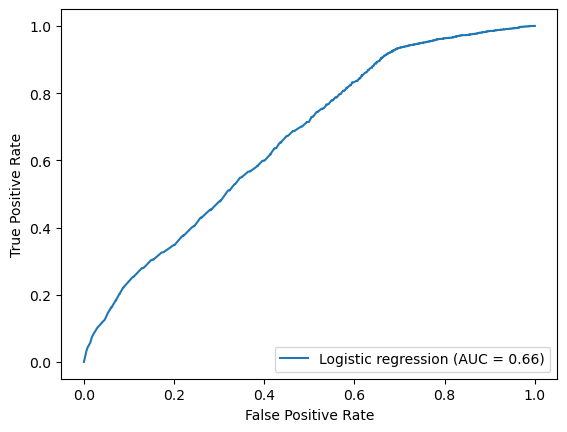

In [10]:
## the whole curve

fpr, tpr, thresholds = roc_curve(y, pred)

roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='Logistic regression')
display.plot()
plt.show()



## 2-2 Tree-based models

### 2-2-1 A show case

With the same processed data as linear model:
Accuracy on training data = 0.7520
ROC AUC score on training data = 0.8181


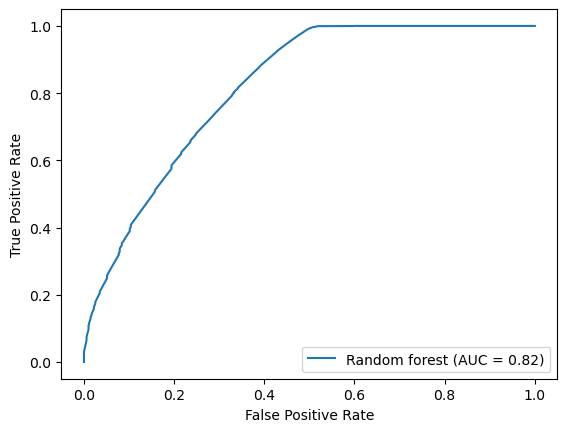

In [11]:
## Wait........ feel the burn......

## a new tree based model
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

## all the same pipeline
print("With the same processed data as linear model:")
rf_model.fit(X, y)


print("Accuracy on training data = {:.4f}".format(rf_model.score(X, y)))
print("ROC AUC score on training data = {:.4f}".format(roc_auc_score(y, rf_model.predict_proba(X)[:,1])))

fpr, tpr, thresholds = roc_curve(y, rf_model.predict_proba(X)[:,1])

roc_auc = auc(fpr, tpr)

display_rf = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='Random forest')

display_rf.plot()
#plt.show()

##


In [12]:
## it just works!!

rf_model = RandomForestClassifier()

print("With the no-feature-engineering data (missing value only):")
rf_model.fit(space_train.loc[:, features_in_model].fillna(-1), y)

print("Accuracy on training data = {:.4f}".format(rf_model.score(space_train.loc[:, features_in_model].fillna(-1), y)))
print("ROC AUC score on training data = {:.4f}".format(roc_auc_score(y, rf_model.predict_proba(X)[:,1])))


## with test data
print("Accuracy on test data = {:.4f}".format(rf_model.score(space_test.loc[:, features_in_model].fillna(-1), 
                                                             space_test.loc[:, "Transported"].replace({True:1, False:0}))))
print("ROC AUC score on test data = {:.4f}".format(roc_auc_score(space_test.loc[:, "Transported"].replace({True:1, False:0}), 
                                                                 rf_model.predict_proba(space_test.loc[:, features_in_model].fillna(-1))[:,1])))



With the no-feature-engineering data (missing value only):
Accuracy on training data = 0.7577
ROC AUC score on training data = 0.8171
Accuracy on test data = 0.6268
ROC AUC score on test data = 0.6458


## 2-2-2 Random Forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

In [13]:
## We already have a random forest model above
## just dig into it

## it is constructed by many DecisionTrees
rf_model.estimator_

DecisionTreeClassifier()

In [14]:
## 100 trees
rf_model.n_estimators

100

In [15]:
## As the manual shows, there are tons of hyperparameters to be set

rf_model = RandomForestClassifier(
    ## number of trees in forest, usually the more the better
    n_estimators = 300,
    ## these two controls the size of a tree = prune
    ## the depth is big means the tree is big
    ## the leaf is big means the tree is small (why?)
    max_depth = 10, 
    min_samples_leaf = 5,
    ## how many features can a decision tree use?
    max_features =  "sqrt",
    ## these two are the key of random forest
    bootstrap = True,
    oob_score = True,
    ## multi-processing
    n_jobs = 3,
    ## showing messeges
    verbose = 1
)

print("With the no-feature-engineering data (missing value only):")
rf_model.fit(space_train.loc[:, features_in_model].fillna(-1), y)

print("Accuracy on training data = {:.4f}".format(rf_model.score(space_train.loc[:, features_in_model].fillna(-1), y)))
print("ROC AUC score on training data = {:.4f}".format(roc_auc_score(y, rf_model.predict_proba(X)[:,1])))


## with test data
print("Accuracy on test data = {:.4f}".format(rf_model.score(space_test.loc[:, features_in_model].fillna(-1), 
                                                             space_test.loc[:, "Transported"].replace({True:1, False:0}))))
print("ROC AUC score on test data = {:.4f}".format(roc_auc_score(space_test.loc[:, "Transported"].replace({True:1, False:0}), 
                                                                 rf_model.predict_proba(space_test.loc[:, features_in_model].fillna(-1))[:,1])))



With the no-feature-engineering data (missing value only):


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s


Accuracy on training data = 0.6793
ROC AUC score on training data = 0.7355
Accuracy on test data = 0.6580
ROC AUC score on test data = 0.6874


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    0.1s finished


In [16]:
## Random forest offers an approximation of "accuracy on test set": oob score
print("""Accuracy on test data (2693 rows) = {:.4f},
the oob score on training data (6000 rows) = {:.4f}""".format(rf_model.score(space_test.loc[:, features_in_model].fillna(-1), 
                                                             space_test.loc[:, "Transported"].replace({True:1, False:0})), 
                                                                    rf_model.oob_score_))
##

Accuracy on test data (2693 rows) = 0.6580,
the oob score on training data (6000 rows) = 0.6642


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    0.1s finished


In [17]:
## There are more than predicted value

rf_model.feature_importances_

array([0.25313461, 0.74686539])

In [18]:
print("Feature improtance is this 2-variable model")
for p in zip(features_in_model, rf_model.feature_importances_):
    print("%s: %f" % (p[0], p[1]))

Feature improtance is this 2-variable model
Age: 0.253135
RoomService: 0.746865


In [19]:
## a different version of feature importance 
## https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html

from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_model, 
    space_test.loc[:, features_in_model].fillna(-1), 
    space_test.loc[:, "Transported"].replace({True:1, False:0}), 
n_repeats=10, random_state=randomState, n_jobs=3
)

forest_importances = pd.Series(result.importances_mean, index=features_in_model)

forest_importances

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Do

Age           -0.0029
RoomService    0.1646
dtype: float64

## 2-3 Cross validation 
https://scikit-learn.org/stable/modules/cross_validation.html

In [20]:
### of course you can make the Cross validation procedure by yourself
### define model, cut training data into k fold, choose k-1 to train and 1 for evaluation
### repeat this for n times.....

### or we can use a predefined procedure
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold


rf_model_cv = RandomForestClassifier(
    n_estimators = 300,
    max_depth = 10, 
    min_samples_leaf = 5,
    max_features =  "sqrt",
    bootstrap = True,
    oob_score = True
)


# define evaluation procedure
rf_cv = RepeatedKFold(n_splits=5 , n_repeats=10, random_state=randomState)

# evaluate model
rf_cv_scores = cross_val_score(rf_model_cv, 
                         X = space_train.loc[:, features_in_model].fillna(-1), 
                         y = y,
                         cv= rf_cv, 
                               n_jobs=-1)
# summarize performance
print('Mean CV Accuracy: %.5f' % np.mean(rf_cv_scores))



Mean CV Accuracy: 0.66220


In [21]:
print("Accuracy on training data = {:.4f}".format(rf_model.score(space_train.loc[:, features_in_model].fillna(-1), y)))

print("Accuracy on test data = {:.4f}".format(rf_model.score(space_test.loc[:, features_in_model].fillna(-1), 
                                                             space_test.loc[:, "Transported"].replace({True:1, False:0}))))

Accuracy on training data = 0.6793
Accuracy on test data = 0.6580


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    0.1s finished


In [ ]:
### best scenario for CV: hyperparameter tuning

rf_model_cv = RandomForestClassifier(
    n_estimators = 300,
    criterion = "entropy", ## a different measure of the splitting quality
    max_depth = 10, 
    min_samples_leaf = 20, ## from 5 to 20
    max_features =  "sqrt",
    bootstrap = True,
    oob_score = True
)



# define evaluation procedure
rf_cv = RepeatedKFold(n_splits=5 , n_repeats=10, random_state=randomState)

# evaluate model
rf_cv_scores = cross_val_score(rf_model_cv, 
                         X = space_train.loc[:, features_in_model].fillna(-1), 
                         y = y,
                         cv= rf_cv, 
                               n_jobs=-1)
# summarize performance
print('Mean CV Accuracy: %.5f' % np.mean(rf_cv_scores))



## Homeworks

1. Read the docs of scikit-learn about the random forest
2. Try some different feature pre-processing method and hyperparameters. Then evaluate them with CV manner
3. How about some different scoring method? (default: accuracy)
4. Record the settings and following scores, which one is the best? why?

